# Text Classification of Movie Plots to Predict Movie Genre

Importing The Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib  inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

Read data into pandas

In [ ]:
#download datasets from https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
df = pd.read_csv('/content/wiki_movie_plots_deduped.csv')
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


Descriptive Statistics

In [ ]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


There are 34886 rows and 8 columns

In [ ]:
df.shape

(34886, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Exploratory Data Analysis

Movie Distributions by Release Year

Text(0, 0.5, 'Frequency of Occurence')

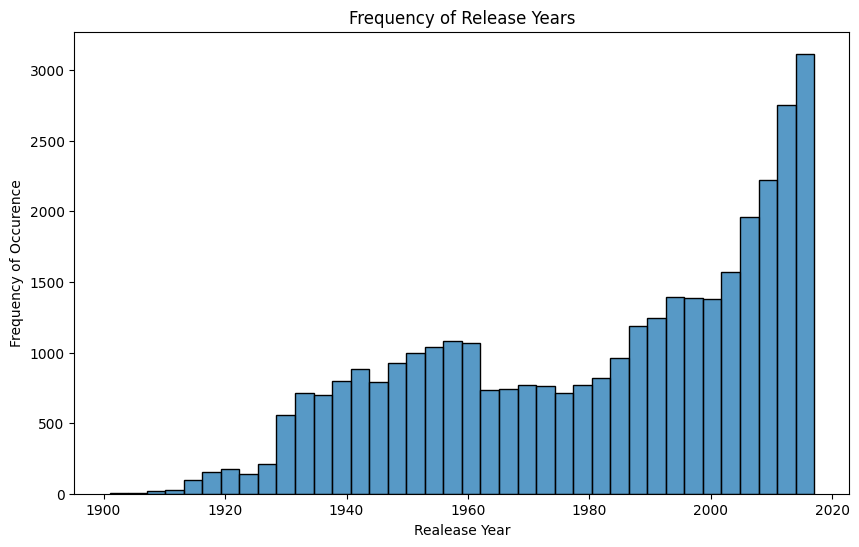

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Release Year')
plt.title('Frequency of Release Years')
plt.xlabel('Realease Year')
plt.ylabel('Frequency of Occurence')

Movie distribution by Movie Origin

Text(0, 0.5, 'Frequency Distribution')

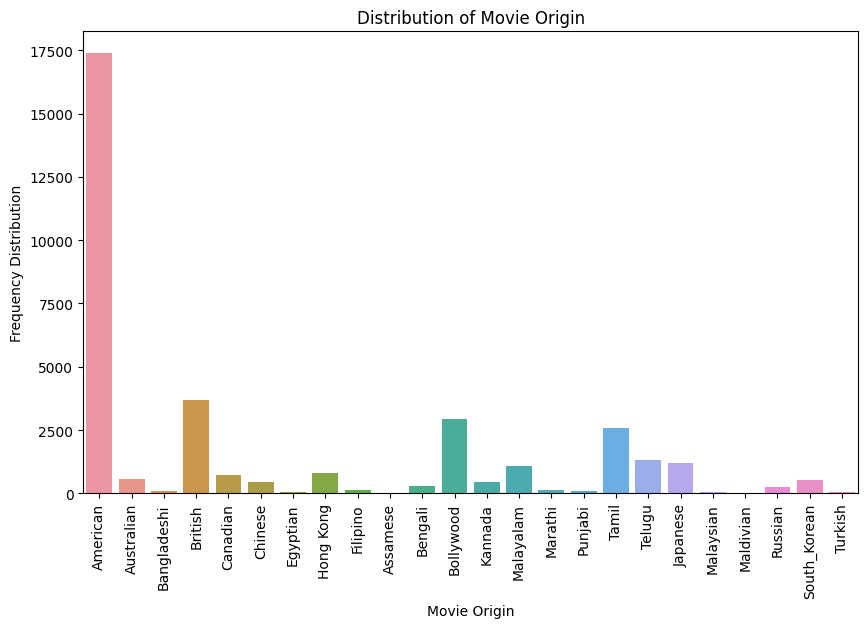

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df, x='Origin/Ethnicity')
plt.xticks(rotation = 90)
plt.title('Distribution of Movie Origin')
plt.xlabel('Movie Origin')
plt.ylabel('Frequency Distribution')

Removing columns with unknown Genres and reseting index





In [ ]:
df = df[df['Genre'] != 'unknown']
df.reset_index(drop=True, inplace=True)
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
1,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
2,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...
3,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...
4,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...


Checking the number of unique values we have in the genres column



In [ ]:
genres=pd.value_counts(df.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  2264 different Genres in the dataset:
--------------------------------------------------
drama                            5964
comedy                           4379
horror                           1167
action                           1098
thriller                          966
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2264, dtype: int64


Getting the top 6 most commonly occuring genres in the dataset

In [ ]:
top_genres = pd.DataFrame(genres[:6]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,5964
1,comedy,4379
2,horror,1167
3,action,1098
4,thriller,966
5,romance,923


Movie distribution of the top six genres in the dataset

Text(0, 0.5, 'frequency')

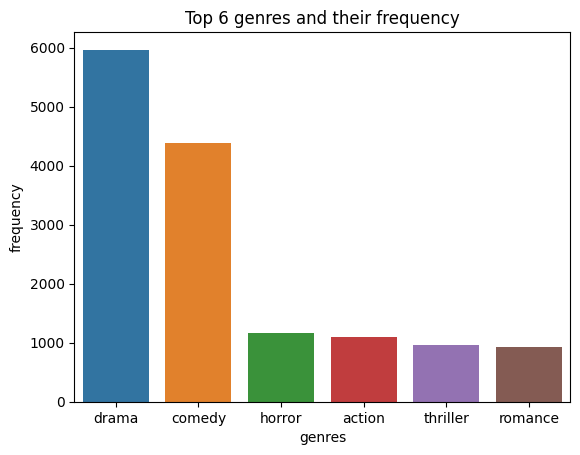

In [ ]:
sns.barplot(data=top_genres, x='genres', y='number_of_movies')
plt.title('Top 6 genres and their frequency')
plt.xlabel('genres')
plt.ylabel('frequency')

Creating separate labels column for the top 6 genres only

In [ ]:
conditions = [df['Genre']=='drama', df['Genre']=='comedy', df['Genre']=='horror', df['Genre']=='action', df['Genre']=='thriller',
             df['Genre']=='romance']
choices = [1,2,3,4,5,6]
df['labels'] = np.select(conditions, choices, 0)

In [ ]:
df.sample(3)


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
14608,2006,Jimmy and Judy,American,"Randall Rubin, Jon Schroder","Edward Furlong, Rachael Bella",crime drama,https://en.wikipedia.org/wiki/Jimmy_and_Judy,"A teenage outcast road movie, Jimmy and Judy f...",0
8929,1975,Race with the Devil,American,Jack Starrett,"Peter Fonda, Warren Oates",thriller,https://en.wikipedia.org/wiki/Race_with_the_Devil,Roger Marsh and Frank Stewart own a successful...,5
10116,1985,Perfect,American,James Bridges,"John Travolta, Jamie Lee Curtis, Jann Wenner, ...",drama,https://en.wikipedia.org/wiki/Perfect_(film),Rolling Stone reporter Adam Lawrence (John Tra...,1


In [ ]:
df['labels'].value_counts()

0    14306
1     5964
2     4379
3     1167
4     1098
5      966
6      923
Name: labels, dtype: int64

In [ ]:
 df_to_use = (df.loc[df['labels']!=0]).reset_index(drop=True)
 df_to_use

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,2
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,2
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,2
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1
...,...,...,...,...,...,...,...,...,...
14492,2011,White as Snow,Turkish,Selim Güneş,"Hakan Korkmaz, Sinem İslamoğlu & Gürkan Piri O...",drama,https://en.wikipedia.org/wiki/White_as_Snow_(f...,Hasan is a twelve-year-old boy living with his...,1
14493,2011,Once Upon a Time in Anatolia,Turkish,Nuri Bilge Ceylan,"Yılmaz Erdoğan, Taner Birsel & Ufuk Karaali",drama,https://en.wikipedia.org/wiki/Once_Upon_a_Time...,"Through the night, three cars carry a small gr...",1
14494,2013,Selam,Turkish,Levent Demirkale,"Bucin Abdullah, Selma Alispahic, Tina Cvitanov...",drama,https://en.wikipedia.org/wiki/Selam_(film),The film opens with a Senegalese boy named Kha...,1
14495,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",2


Text(0, 0.5, 'Frequency of Occurence')

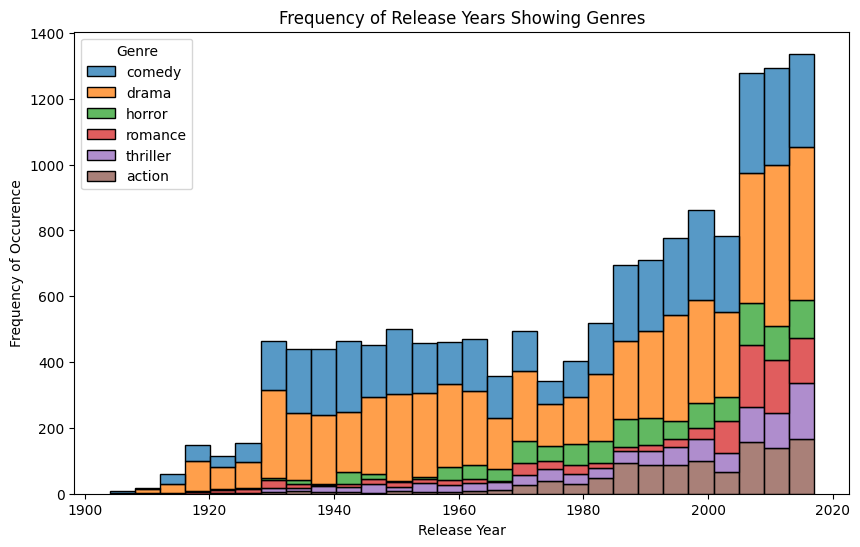

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x = 'Release Year', hue = 'Genre', data = df_to_use, multiple = 'stack')
plt.title('Frequency of Release Years Showing Genres')
plt.xlabel('Release Year')
plt.ylabel('Frequency of Occurence')

Dropping unnecessary columns

In [ ]:
df_to_use.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)
df_to_use.head()

,Title,Genre,Plot,labels
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2
2,Laughing Gas,comedy,The plot is that of a black woman going to the...,2
3,The Adventures of Dollie,drama,On a beautiful summer day a father and mother ...,1
4,The Black Viper,drama,A thug accosts a girl as she leaves her workpl...,1


## Cleaning up the 'Plot' column for Analysis

In [ ]:
df_to_use['Plot'][2]

'The plot is that of a black woman going to the dentist for a toothache and being given laughing gas. On her way walking home, and in other situations, she can\'t stop laughing, and everyone she meets "catches" the laughter from her, including a vendor and police officers.'

## Total number of words in the Plot summaries

In [ ]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(df_to_use['Plot'])
print(raw_length)

5240143


## Total number of UNIQUE words in the plot summaries

In [ ]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_unique_length = unique_word_length(df_to_use['Plot'])
print(raw_unique_length)

253147


## Creating our stopwords list and adding some more words that are very common in the summaries. Changing the text to lower case, stopwords removal, lemmatizing.

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells']
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = ' '.join(text)
    text = nlp(text)
    text = [w.lemma_ for w in text]
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text


In [ ]:
new_df = df_to_use.copy(deep = True)

In [ ]:
new_df['Plot'] = new_df['Plot'].map(lambda x : clean_text(x))
new_df['Plot'][5]

'young couple decide elope catch midst romantic moment woman angry father make plan leave thief discover plan hide trunk wait right moment steal belonging'

## Clean word length vs without cleaning word length Comparison

In [ ]:
clean_length = word_length(new_df['Plot'])
clean_unique_length = unique_word_length(new_df['Plot'])

In [ ]:
print(f'clean length is {clean_length} vs Raw lenght is {raw_length}')
print(f'clean unique length is {clean_unique_length} vs Raw unique lenght is {raw_unique_length}')

clean length is 2867712 vs Raw lenght is 5240143
clean unique length is 70730 vs Raw unique lenght is 253147


# Modeling


Assigning Independent and Target Variables and performing train test split into training and testing set

In [ ]:
X = new_df['Plot']
y = new_df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10872,) (3625,) (10872,) (3625,)


Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model, Logistic Regression Model and Decision Tree


In [ ]:
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15, lowercase=False)
tfidf_Xtr = vectorizer.fit_transform(X_train)

Multinomial Naive Bayes gave accuracy of ~56%

In [ ]:
mnb = MultinomialNB()
mnb.fit(tfidf_Xtr, y_train)
accuracy_score(mnb.predict(vectorizer.transform(X_test)), y_test)

0.5594482758620689

Logistic Regression gave accuracy of ~64%

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(tfidf_Xtr, y_train)
accuracy_score(lr.predict(vectorizer.transform(X_test)), y_test)

0.6358620689655172

Desicion Tree gave an accuracy of 43%

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(tfidf_Xtr, y_train)
accuracy_score(dtc.predict(vectorizer.transform(X_test)), y_test)

0.43144827586206896

Random forest gave an accuracy of 55%

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(tfidf_Xtr, y_train)
accuracy_score(rfc.predict(vectorizer.transform(X_test)), y_test)

0.5495172413793104

## XGBOOST classifier gace an accuracy of 61%

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(tfidf_Xtr, y_train-1)
accuracy_score(xgb.predict(vectorizer.transform(X_test)), y_test-1)

0.6104827586206897